In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import sys
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

In [2]:
import astropy.units as u
import lightkurve as lk

In [3]:
def fold(lc, period, t0):
    t0_btjd = t0 - 2457000
    return lc.fold(period=period, epoch_time=t0_btjd)
class TESSPlanetTransit:
    def __init__(self, name, period=None, t0=None, lc = None, depth=None, duration=None, impact=None):
        self.name = name
        self.period = period
        self.t0 = t0
        folded_lc = fold(lc, period, t0)
        self.time = np.array(folded_lc.time.value)
        self.flux = np.array(folded_lc.flux.value)
        self.depth = depth
        self.duration = duration
        self.impact = impact
    

In [4]:
import pickle

with open("transits_raw_condition.pkl", "rb") as f:

    transits = pickle.load(f)


In [5]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

In [6]:
SIZE = 4096
def resample_phase_flux(phase, flux, target_len=SIZE):
    
    flux = np.array(flux)
    phase = np.array(phase)
    mask = ~np.isnan(phase) & ~np.isnan(flux)

    phase = phase[mask]
    flux = flux[mask]

    sort_idx = np.argsort(phase)
    phase = phase[sort_idx]
    flux = flux[sort_idx]

    phase_target = np.linspace(phase[0],phase[-1], target_len)

    flux_interp = np.interp(phase_target, phase, flux)
    
    
    flux_interp = (flux_interp - np.min(flux_interp)) / (np.max(flux_interp) - np.min(flux_interp))

    return np.stack([phase_target, flux_interp], axis=-1)

data = []
for i in range(len(transits)):
    data.append(resample_phase_flux(transits[i].time, transits[i].flux))

data = np.array(data)
data.shape

(448, 4096, 2)

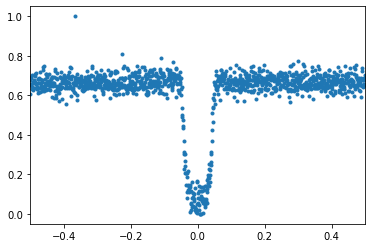

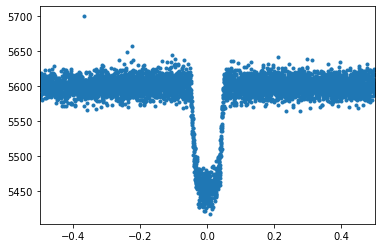

In [7]:
plt.plot(data[199][:,0], data[199][:,1],".")
plt.xlim(-0.5, 0.5)
plt.show()

plt.plot(transits[199].time, np.array(transits[199].flux),".")
plt.xlim(-0.5, 0.5)
plt.show()

In [8]:
depths = np.array([t.depth for t in transits])
durations = np.array([t.duration for t in transits])
impacts = np.array([t.impact for t in transits])

conditions = np.stack([depths, durations, impacts], axis=-1)
cond_mean = conditions.mean(axis=0)
cond_std = conditions.std(axis=0)
conditions_norm = (conditions - cond_mean) / cond_std

In [9]:
X_train, X_test, cond_train, cond_test = train_test_split(data, conditions_norm, test_size=0.2, random_state=42)

In [10]:
LATENT_SPACE_SIZE = 16
input_data = tensorflow.keras.layers.Input(shape=(SIZE, 2))
input_cond = tensorflow.keras.layers.Input(shape=(3,))

x = tensorflow.keras.layers.Conv1D(64, 5, activation='relu', padding='same')(input_data)
x = tensorflow.keras.layers.MaxPooling1D(2)(x)
x = tensorflow.keras.layers.Conv1D(32, 5, activation='relu', padding='same')(x)
x = tensorflow.keras.layers.MaxPooling1D(2)(x)
x = tensorflow.keras.layers.Conv1D(16, 5, activation='relu', padding='same')(x)
x = tensorflow.keras.layers.MaxPooling1D(2)(x)

x = tensorflow.keras.layers.Flatten()(x)
x = tensorflow.keras.layers.Concatenate()([x, input_cond])
x = tensorflow.keras.layers.Dense(16, activation='relu')(x)

distribution_mean = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_mean')(x)
distribution_variance = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_log_variance')(x)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])


encoder_model = tensorflow.keras.Model([input_data, input_cond], [distribution_mean, distribution_variance, latent_encoding], name="encoder")
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4096, 2)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 4096, 64)     704         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 2048, 64)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2048, 32)     10272       ['max_pooling1d[0][0]']          
                                                                                            

In [11]:
latent_input = tensorflow.keras.layers.Input(shape=(LATENT_SPACE_SIZE,))
cond_input = tensorflow.keras.layers.Input(shape=(3,))
x = tensorflow.keras.layers.Concatenate()([latent_input, cond_input])

x = tensorflow.keras.layers.Dense(512 * 8, activation='relu')(x)
x = tensorflow.keras.layers.Reshape((512, 8))(x)
x = tensorflow.keras.layers.UpSampling1D(2)(x)
x = tensorflow.keras.layers.Conv1DTranspose(16, 5, activation='relu', padding='same')(x)
x = tensorflow.keras.layers.UpSampling1D(2)(x)
x = tensorflow.keras.layers.Conv1DTranspose(32, 5, activation='relu', padding='same')(x)
x = tensorflow.keras.layers.UpSampling1D(2)(x)
x = tensorflow.keras.layers.Conv1DTranspose(64, 5, activation='relu', padding='same')(x)

decoder_output = tensorflow.keras.layers.Conv1DTranspose(2, 5, activation='sigmoid', padding='same')(x)
decoder_model = tensorflow.keras. Model([latent_input, cond_input], decoder_output, name="decoder")
decoder_model.summary()


Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 19)           0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 4096)         81920       ['concatenate_1[0][0]']    

In [12]:


def get_loss(distribution_mean, distribution_variance, factor, batch_size):

    def get_reconstruction_loss(y_true, y_pred, factor, batch_size):
        reconstruction_loss = tensorflow.math.squared_difference(
            y_true[:, :, 1],  # true flux
            y_pred[:, :, 1]   # predicted flux
        )
        reconstruction_loss_batch = tensorflow.reduce_sum(reconstruction_loss)/batch_size
        print_op = tensorflow.print("\nmse", 0.5*reconstruction_loss_batch*factor, output_stream="file://./test.txt")
        with tensorflow.control_dependencies([print_op]):
            res = 0.5*reconstruction_loss_batch*factor
        return res

    def get_kl_loss(distribution_mean, distribution_variance, batch_size):
        print_op = tensorflow.print("\nvariance", distribution_variance, output_stream="file://./test.txt")
        with tensorflow.control_dependencies([print_op]):
            distribution_variance = tensorflow.clip_by_value(distribution_variance, -10.0, 10.0)
        kl_loss = LATENT_SPACE_SIZE + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_sum(kl_loss)/batch_size
        print_op = tensorflow.print("\nkl", kl_loss_batch*(-0.5), output_stream="file://./test.txt")
        with tensorflow.control_dependencies([print_op]):
            res = kl_loss_batch*(-0.5)
        return res

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred, factor, batch_size)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance, batch_size)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

In [13]:
z_mean, z_logvar, z = encoder_model([input_data, input_cond])
decoded_train = decoder_model([z, input_cond])
autoencoder = tensorflow.keras.Model(inputs=[input_data, input_cond], outputs=decoded_train)

In [14]:
batch_size = 64
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 1.0,
                                  batch_size = batch_size), optimizer='adam')
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4096, 2)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 encoder (Functional)           [(None, 16),         145232      ['input_1[0][0]',                
                                 (None, 16),                      'input_2[0][0]']                
                                 (None, 16)]                                                      
                                                                                              

In [15]:
X_train_noisy = X_train + np.random.normal(0, 0.002, size=X_train.shape)
autoencoder.fit(
    [X_train_noisy, cond_train], 
    X_train,   
    epochs=50,
    batch_size=64,
    validation_data=([X_test, cond_test], X_test),
)

Train on 358 samples, validate on 90 samples
Epoch 1/50
358/358 [==============================] - ETA: 0s - loss: -52.8042

/Users/nina/anaconda3/envs/sds365/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


358/358 [==============================] - 52s 146ms/sample - loss: -52.8042 - val_loss: -48.3969
Epoch 2/50
358/358 [==============================] - 3s 9ms/sample - loss: -55.9655 - val_loss: -48.0916
Epoch 3/50
358/358 [==============================] - 3s 9ms/sample - loss: -58.1398 - val_loss: -50.6800
Epoch 4/50
358/358 [==============================] - 3s 9ms/sample - loss: -61.0472 - val_loss: -53.5205
Epoch 5/50
358/358 [==============================] - 3s 9ms/sample - loss: -66.9242 - val_loss: -58.5897
Epoch 6/50
358/358 [==============================] - 3s 9ms/sample - loss: -70.5488 - val_loss: -60.3978
Epoch 7/50
358/358 [==============================] - 4s 11ms/sample - loss: -72.3060 - val_loss: -62.0172
Epoch 8/50
358/358 [==============================] - 4s 11ms/sample - loss: -72.4093 - val_loss: -62.8946
Epoch 9/50
358/358 [==============================] - 5s 13ms/sample - loss: -74.1313 - val_loss: -62.6853
Epoch 10/50
358/358 [==============================

Text(0.5, 1.0, 'Reconstructed')

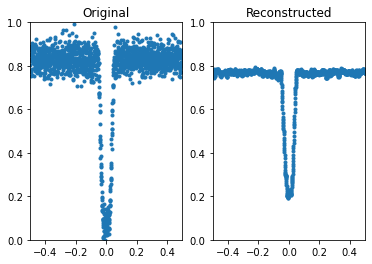

In [25]:
i = 30
one_sample = X_test[i]
one_cond   = cond_test[i]
fig, axs = plt.subplots(1, 2)
axs[0].plot(one_sample[:,0], one_sample[:,1], ".")
axs[0].set_ylim(0,1)
axs[0].set_xlim(-0.5, 0.5)
axs[0].set_title("Original")
reconstructed = autoencoder.predict([one_sample.reshape(1, SIZE, 2), one_cond.reshape(1, 3)])[0]
axs[1].plot(one_sample[:,0], reconstructed[:,1], ".")
axs[1].set_ylim(0,1)
axs[1].set_xlim(-0.5, 0.5)
axs[1].set_title("Reconstructed")

In [17]:
def GenerateTransits(X_test, cond_test, LATENT_SPACE_SIZE, noise_level):
    sample_index = random.sample(range(1, len(X_test)), 15)
    X_samples = X_test[sample_index]
    cond_samples = cond_test[sample_index]
    z_mean, _, _ = encoder_model.predict([X_samples, cond_samples])
    latent_space = z_mean + noise_level * np.random.normal(size=z_mean.shape)
    generated_transit = decoder_model.predict([latent_space, cond_samples])
    
    fig = plt.figure(figsize=(15,10))
    number_of_images = len(generated_transit)
    for i in range(number_of_images):
        ax = fig.add_subplot(3, 5, i+1)
        ax.plot(generated_transit[i][:,1])
    return generated_transit

/Users/nina/anaconda3/envs/sds365/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


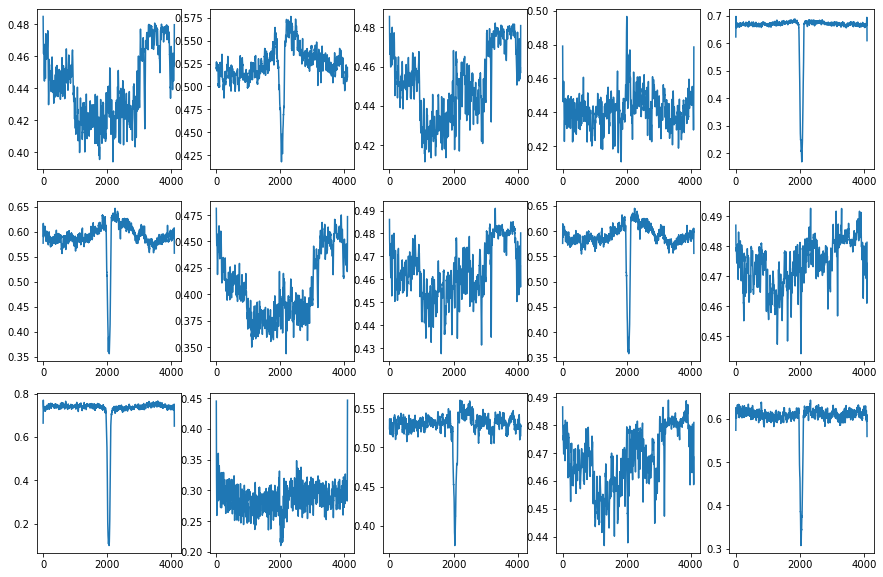

In [18]:
generated_transits = GenerateTransits(X_test, cond_test, LATENT_SPACE_SIZE, noise_level=0.01)

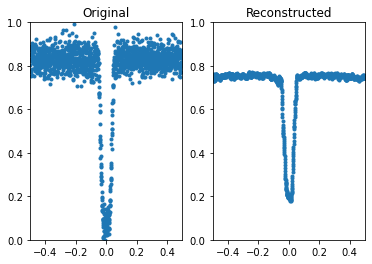

In [33]:
X_example = np.expand_dims(X_test[30].copy(), axis=0)
cond_example = np.expand_dims(cond_test[30].copy(), axis=0)
z_mean, _, _ = encoder_model.predict([X_example, cond_example])
latent_space = z_mean + 0.1 * np.random.normal(size=z_mean.shape)
cond_example[0,1] += 0.5
generated_transit = decoder_model.predict([latent_space, cond_example])
fig, axs = plt.subplots(1, 2)
axs[0].plot(X_example[0,:,0], X_example[0,:,1], ".")
axs[0].set_ylim(0,1)
axs[0].set_xlim(-0.5, 0.5)
axs[0].set_title("Original")
axs[1].plot(X_example[0,:,0], generated_transit[0,:,1], ".")
axs[1].set_ylim(0,1)
axs[1].set_xlim(-0.5, 0.5)
axs[1].set_title("Reconstructed")
plt.show()